In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
from scipy.stats import multivariate_normal as mvn
markers = ['*','+','.','1']
from DM2 import fmt_output, EM_algorithm as GMM
np.seterr(divide='ignore');

In [2]:
# train and test datasets
train = pd.read_csv('Data/EMGaussian.data',sep=" ", names=["x","y"])
test  = pd.read_csv('Data/EMGaussian.test',sep=" ", names=["x","y"])
# number of Clusters 
K = 4

### Qyestion 1.   sum-product algorithm:
Using $\alpha$ and $\beta$ recursions to estimate $p(q_t|u_1,\dots,u_T)$ and $p(q_t, q_{t+1}|u_1,\dots,u_T)$

In [3]:
class SumProd:
    def __init__(self, data, K, A, p0, means, covs):
        self.K   = K
        self.A   = A                                         # transition matrix A[i,j] = p(q_(t+1)=i |q_t=j).  Shape (K,K) 
        self.T   = len(data)                                 
        self.p0  = p0                                        # p(q_1|u1,...,u_T).                               Shape (K)
        self.data  = data                                    # data set [u_1,...u_T] (d=2)                      Shape (T,d)
        self.means = means                                   # list of centers mu_j.                            Shape (K,d)
        self.covs  = covs                                    # list of covariance matrices.                     Shape (K,d,d)
        self.log_pu = None                                   # log(p(u_1,...,u_T)). Scalar
        self.cond_pt = None                                  # cond_pt[t,j] = p(q_t=j |u_1,...,u_T).            Shape (T,K)
        self.cond_mt = np.zeros((self.T-1,self.K,self.K))    # matrix cond_mt[t,i,j]=p(q_(t+1)=i, q_t=j |u_1,...,u_T)
                                                                                                              # Shape (T,K,K)
    
    def emission(self, u):
        # p(u_t|q_t) for q_t = 1 to K
        return np.array([mvn.pdf(u, self.means[j], self.covs[j]) for j in range(self.K)])
    
    def alpha(self):
        # returns the logarithm of alpha_t(q_t) (matrix TxK)
        log_a = np.zeros((self.T, self.K))
        log_a[0] = np.log(self.emission(self.data.iloc[0])) + np.log(self.p0)
        for t in range(self.T-1):
            log_a_max = log_a[t].max()
            p = np.exp(log_a[t] - log_a_max)
            log_a[t+1] = np.log(self.emission(self.data.iloc[t+1])) + np.log(np.dot(self.A,p)) + log_a_max
        return log_a
    
    def beta(self):
        # returns the logarithm of beta_t(q_t) (matrix TxK)
        log_b = np.zeros((self.T, self.K))
        for t in range(self.T-2, -1, -1):
            log_b_max = log_b[t+1].max()
            p = np.exp(log_b[t+1] - log_b_max + np.log(self.emission(self.data.iloc[t+1])))
            log_b[t] = np.log(np.dot(self.A.T,p)) + log_b_max
        return log_b
    
    def sum_prod(self):
        # calculates p0, log(p(u_1,...,u_T)), cond_pt, and cond_mt
        log_a = self.alpha()
        log_b = self.beta()
        max_ab = (log_a+log_b).max()
        self.log_pu = np.log(np.sum(np.exp(log_a[-1]+log_b[-1]-max_ab))) + max_ab
        self.cond_pt = np.exp(log_a + log_b - max_ab)
        self.cond_pt = self.cond_pt/self.cond_pt.sum(axis=1)[:,None]
        for t in range(self.T-1):
            _temp = np.log(self.emission(self.data.iloc[t+1]))
            self.cond_mt[t] = np.add.outer(log_b[t+1],log_a[t]) + np.log(self.A) + _temp[:,None]
            self.cond_mt[t] -= self.cond_mt[t].max()
        self.cond_mt = np.exp(self.cond_mt)
        self.p0 = self.cond_pt[0]

### Question 4.   max-product algorithm:
Algorithm to infer the sequence of most likely states $\text{arg max}_q p(q_1,\dots,q_T|u_1,\dots,u_T)$

In [4]:
class MaxProd(SumProd): 
    # inherits attributes from SumProd
    def __init__(self, data, K, A, p0, means, covs):
        super(MaxProd,self).__init__(data, K, A, p0, means, covs)
    def max_prod(self):
        # Viterbi algorithm (usual dynamic programming)
        max_p = np.zeros((self.T, self.K))
        prev  = np.zeros((self.T, self.K))
        max_p[0] = np.log(self.p0) + np.log(self.emission(self.data.iloc[0]))
        for t in range(1,self.T):
            _temp = max_p[t-1][None,:] + np.log(self.emission(self.data.iloc[t]))[:,None] + np.log(self.A)
            max_p[t] = _temp.max(axis=1)
            prev[t]  = _temp.argmax(axis=1)
        q     = np.zeros(self.T,dtype=int)
        q[-1] = max_p[-1].argmax()
        for t in range(self.T-2,-1,-1):
            q[t] = prev[t+1][q[t+1]]
        return q

### Question 3.   EM algorithm for HMM:

In [5]:
class HMM(SumProd):
    # inherits most of the attributes from SumProd
    def __init__(self, data, K):
        # we use GMM from DM2 to initialize means and covariance matrices as well as p0 and A
        model = GMM(data, K)
        model.fit(tol=1e-6)
        #A = np.ones((K,K))/float(K)
        A = np.repeat([model.p_j], K, axis=0).T                                        # for GMM, (q_t) are i.i.d
        super(HMM,self).__init__(data, K, A, model.p_j, model.centers, model.sigmas)   # initializing the super class attributes
        self.iters   = 0                                                               # number of iterations
        self.old_ll  = 0.0                                                             # old value of the log likelihood
        self.new_ll  = 0.0                                                             # new value of the log likelihood
        
    def E_step(self):
        # Expectation step: update of the distribution of q_t | u_1,...,u_T
        self.sum_prod()
        
    def M_step(self):
        # Maximization step: update of means and covariance matrices by maximazing the expected log-likelihood
        self.A     = np.sum(self.cond_mt,axis=0)/np.sum(self.cond_mt,axis=(0,1))[None,:]
        self.means = np.dot(self.cond_pt.T,self.data.values)
        self.means = self.means/self.cond_pt.sum(axis=0)[:,None]
        for k in range(self.K):
            delta = self.data.values-self.means[k]
            self.covs[k] = np.dot(delta.T,self.cond_pt[:,k][:,None]*delta)/np.sum(self.cond_pt[:,k])

    def update_ll(self):
        # update of the complete log-likelihood log(p(u_1,...,u_T))
        self.old_ll = self.new_ll
        self.new_ll = self.log_pu
        
    def update(self):
        # 1 step of the EM algorithm loop
        self.E_step()
        self.M_step()
        self.update_ll() 
            
    def fit(self, tol=1e-6, max_iters=100, verbose=False):
        if self.iters == 0 :
            self.update()
            self.iters += 1
            if verbose:
                print('Iteration: 01, log likelihood: {:.4f}'.format(self.new_ll))
        while(np.abs(self.new_ll-self.old_ll)>tol and self.iters<max_iters):
            # we keep running EM as long the change in the complete log-likelihood is > tol and inters < max_inters
            self.update()
            self.iters += 1
            if verbose and self.iters%10 == 0 :
                print('Iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))
        if verbose:
            print('Last iteration: {:d}, log likelihood: {:.4f}'.format(self.iters, self.new_ll))

    def ll(self, data):
        # calculates the unnormalized /normalized complete log-likelihood of a sample using the learned parameters
        SP = SumProd(data, self.K, self.A, self.p0, self.means, self.covs)
        SP.sum_prod()
        return SP.log_pu, SP.log_pu/SP.T
    
    def predict(self, test):
        # predicts the states q_1,...,q_T using max-product algorithm
        data = test.copy()
        MP   = MaxProd(data, self.K, self.A, self.p0, self.means, self.covs)
        q = MP.max_prod()
        data['state'] = q+1
        return data

### Learning the parameters of HMM (and GMM from last homework):

In [6]:
hmm = HMM(train,K)
hmm.fit(tol=1e-6,verbose=True)
gmm = GMM(train,K)
gmm.fit(tol=1e-6,verbose=False);

Iteration: 01, log likelihood: -2327.7157
Iteration: 10, log likelihood: -1896.9657
Iteration: 20, log likelihood: -1896.9660
Last iteration: 20, log likelihood: -1896.9660


### Learned HMM parameters:

In [7]:
fmt_output(r'(\hat\pi_0)',K,(1,1),hmm.p0)
fmt_output(r'\hat\mu',K,(2,1),hmm.means)
fmt_output(r'\hat\Sigma',K,(2,2),hmm.covs)
fmt_output(r'\hat{p}(q_{t+1} = i|q_t = j)',1,(K,K),hmm.A)
# cluster predictions on the training and test data
clusters_train = hmm.predict(train)
clusters_test  = hmm.predict(test)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)

$(\hat\pi_0)_1=0.00, \quad $$(\hat\pi_0)_2=0.00, \quad $$(\hat\pi_0)_3=0.00, \quad $$(\hat\pi_0)_4=1.00, \quad $

$\hat\mu_1=\begin{bmatrix}-1.95\\4.19\end{bmatrix}, \quad $$\hat\mu_2=\begin{bmatrix}3.99\\3.63\end{bmatrix}, \quad $$\hat\mu_3=\begin{bmatrix}3.79\\-3.98\end{bmatrix}, \quad $$\hat\mu_4=\begin{bmatrix}-2.97\\-3.45\end{bmatrix}, \quad $

$\hat\Sigma_1=\begin{bmatrix}3.27 & 0.30\\0.30 & 2.83\end{bmatrix}, \quad $$\hat\Sigma_2=\begin{bmatrix}0.20 & 0.26\\0.26 & 12.35\end{bmatrix}, \quad $$\hat\Sigma_3=\begin{bmatrix}0.94 & 0.06\\0.06 & 1.55\end{bmatrix}, \quad $$\hat\Sigma_4=\begin{bmatrix}6.81 & 6.59\\6.59 & 6.69\end{bmatrix}, \quad $

$\hat{p}(q_{t+1} = i|q_t = j)=\begin{bmatrix}0.02 & 0.92& 0.04& 0.01\\0.87 & 0.03& 0.05& 0.07\\0.05 & 0.02& 0.87& 0.02\\0.06 & 0.03& 0.03& 0.90\end{bmatrix}, \quad $

### Question 4. continued - most likely states of HMM:

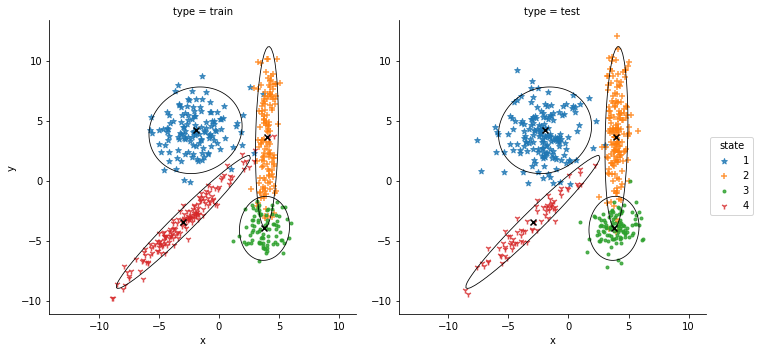

In [8]:
# percentage of distribution inside the ellipse
pct = 0.9
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='state',markers=markers[:K], fit_reg=False)
centers = list(zip(*hmm.means))
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color='black', marker='x');
    xRange = (for_sns['x'].min(), for_sns['x'].max())
    yRange = (for_sns['y'].min(), for_sns['y'].max())
    x = np.linspace(*xRange, 100)
    y = np.linspace(*yRange, 100)
    x, y = np.meshgrid(x, y)
    for j in range(K):
        Inv = np.linalg.inv(hmm.covs[j])
        a, b, c = Inv[0][0], Inv[1][0]+ Inv[0][1], Inv[1][1]
        ax.contour(x, y, a*(x-hmm.means[j][0])**2 + b*(x-hmm.means[j][0])*(y-hmm.means[j][1])+c*(y-hmm.means[j][1])**2
                   ,[-2*np.log(1-pct)], colors = 'k', linewidths=0.8)

### Question 5. comparison of HMM and GMM of the previous homework:

In [9]:
ull = pd.DataFrame(index=['GMM','HMM'],columns=['Train', 'Test'])
nll = pd.DataFrame(index=['GMM','HMM'],columns=['Train', 'Test'])

ull['Train'].loc['GMM'], nll['Train'].loc['GMM'] = gmm.ll(train)
ull['Train'].loc['HMM'], nll['Train'].loc['HMM'] = hmm.ll(train)
ull[ 'Test'].loc['GMM'], nll[ 'Test'].loc['GMM'] = gmm.ll(test)
ull[ 'Test'].loc['HMM'], nll[ 'Test'].loc['HMM'] = hmm.ll(test)
print('Unnormalized log-likelihoods:');display(ull);
print(  'Normalized log-likelihoods:');display(nll);

Unnormalized log-likelihoods:


,Train,Test
GMM,-2327.72,-2408.98
HMM,-1896.97,-1954.46


Normalized log-likelihoods:


,Train,Test
GMM,-4.65543,-4.81796
HMM,-3.79393,-3.90893


### Results on shuffled data:

Unnormalized log-likelihoods:


,Train,Test
GMM,-2327.72,-2408.98
HMM,-2321.86,-2543.69


Normalized log-likelihoods:


,Train,Test
GMM,-4.65543,-4.81796
HMM,-4.64372,-5.08738


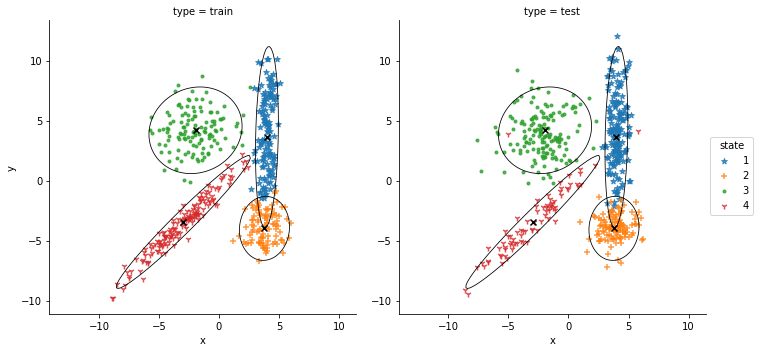

In [34]:
train_sh = train.sample(frac=1.0)
test_sh  = test.sample(frac=1.0)
hmm_sh = HMM(train_sh,K)
hmm_sh.fit(tol=1e-6)
gmm_sh = GMM(train_sh,K)
gmm_sh.fit(tol=1e-6);
clusters_train = hmm_sh.predict(train_sh)
clusters_test  = hmm_sh.predict(test_sh)
clusters_train['type'] = 'train'
clusters_test['type']  = 'test'
for_sns = pd.concat([clusters_train,clusters_test],axis=0)
# percentage of distribution inside the ellipse
pct = 0.9
g = sns.lmplot(data=for_sns, x='x', y='y', col='type', hue='state',markers=markers[:K], fit_reg=False)
centers = list(zip(*hmm.means))
for ax in g.axes[0]:
    plt.gca().set_aspect('equal')
    ax.scatter(*centers, color='black', marker='x');
    xRange = (for_sns['x'].min(), for_sns['x'].max())
    yRange = (for_sns['y'].min(), for_sns['y'].max())
    x = np.linspace(*xRange, 100)
    y = np.linspace(*yRange, 100)
    x, y = np.meshgrid(x, y)
    for j in range(K):
        Inv = np.linalg.inv(hmm.covs[j])
        a, b, c = Inv[0][0], Inv[1][0]+ Inv[0][1], Inv[1][1]
        ax.contour(x, y, a*(x-hmm.means[j][0])**2 + b*(x-hmm.means[j][0])*(y-hmm.means[j][1])+c*(y-hmm.means[j][1])**2
                   ,[-2*np.log(1-pct)], colors = 'k', linewidths=0.8)
ull = pd.DataFrame(index=['GMM','HMM'],columns=['Train', 'Test'])
nll = pd.DataFrame(index=['GMM','HMM'],columns=['Train', 'Test'])

ull['Train'].loc['GMM'], nll['Train'].loc['GMM'] = gmm_sh.ll(train_sh)
ull['Train'].loc['HMM'], nll['Train'].loc['HMM'] = hmm_sh.ll(train_sh)
ull[ 'Test'].loc['GMM'], nll[ 'Test'].loc['GMM'] = gmm_sh.ll(test_sh)
ull[ 'Test'].loc['HMM'], nll[ 'Test'].loc['HMM'] = hmm_sh.ll(test_sh)
print('Unnormalized log-likelihoods:');display(ull);
print(  'Normalized log-likelihoods:');display(nll);